<a href="https://colab.research.google.com/github/mkim797/SFSU---EXCO---Intro-to-Data-Science/blob/master/DiabeticRetinopathyVGG16v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy detection using VGG16

#### *Based HEAVILY from kernal of Dana Elisa Nicolas on Kaggle*

Diabetic Retinopathy is retinal damage caused due to diabetes.

VGG16 is a pretrained CNN created by K. Simonyan and A. Zisserman from the University of Oxford.  It was trained with over 15 million images.

This is the structure of VGG16:

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

More information on VGG16 can be found here:
https://neurohive.io/en/popular-networks/vgg16/

## Split Folders tool

Split folders tool allows for easy seperation of files from one to multiple folders.

In [0]:
!pip install split_folders

## Import Packages

These are the packages we used to implement our neural network.

In [0]:
import split_folders

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import tensorflow as tf
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Mount google drive locally

To simplify the use of data, we mounted a google drive locally.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


## Download data set

This downoaded the data set to our google drive.

In [0]:
#!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

 98% 417M/427M [00:09<00:00, 47.0MB/s]
100% 427M/427M [00:09<00:00, 45.2MB/s]


Unzip Data

In [0]:
!unzip \*.zip  && rm *.zip

Archive:  diabetic-retinopathy-224x224-gaussian-filtered.zip
replace gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
#os.makedirs('output')
#os.makedirs('output/train')
#os.makedirs('output/val')

In [0]:
!ls ..

'Colab Notebooks'   Kaggle


In [18]:
!ls ../Kaggle/gaussian_filtered_images/gaussian_filtered_images

export.pkl  Mild  Moderate  No_DR  Proliferate_DR  Severe


## Split data into training and test sets

We used the split_folders tool to split the data into an 80% mix of training data and 20% testing data.

In [19]:
img_loc = '../Kaggle/gaussian_filtered_images/gaussian_filtered_images'
split_folders.ratio(img_loc, output='output', seed=1, ratio=(0.8, 0.2))

Copying files: 20 files [00:12,  2.02 files/s]

KeyboardInterrupt: ignored

In [0]:
!ls ../Kaggle/output/

In [0]:
train_loc = '../Kaggle/output/train/'
test_loc = '../Kaggle/output/val/'

## ImageDataGenerator

### NOT implemented

ImageDataGenerator is a tool of keras that takes the input image data and augments it by adding image transformations to increase the amount of data.

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [21]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 2929 images belonging to 5 classes.
Found 733 images belonging to 5 classes.


In [31]:
traindata.classes.shape

(2929,)

## VGG16 implementation

Since VGG16 is already implemented for us, using the model is fairly simple.  Since there are five categories of diabetic retinopathy, we need to set the output to those 5 categories.

Additionally, the weights of the parameters are set to the pretrained model "imagenet".

In [0]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

## Make layers trainable

Since VGG16 is a general image recognition model, we want to specify our model for our dataset.  By keeping the parameters of the initial layers of the pretrained model, we can keep the ability of the model to recognize major differences in images.  Then we can train the latter layers of the model so that it can have output that is more specific to our dataset.

In [0]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-12:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)  

Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


In [0]:
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Checkpoints

Checkpoints are created to monitor the accuracy of the model as it trains.  The weights of the parameters are saved when testing accuracy is at its highest and stops early if accuracy is not improving.

In [0]:
checkpoint = ModelCheckpoint("vgg16_diabetes.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

## Weighting of Classes

To ensure that training is happening evenly throughout the dataset, we create a set of weights from one category to another.

In [0]:
counter = Counter(traindata.classes)
max_val = float(max(counter.values()))                     
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 4.878378378378378,
 1: 1.8072590738423029,
 2: 1.0,
 3: 6.11864406779661,
 4: 9.376623376623376}

In [0]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=50,callbacks=[checkpoint,early])

Epoch 1/50
46/91 [==============>...............] - ETA: 8:11 - loss: 71.7670 - accuracy: 0.2785

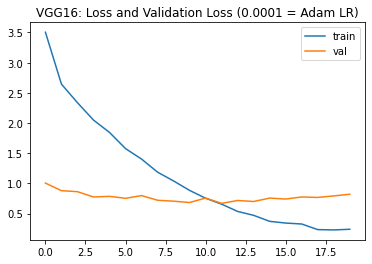

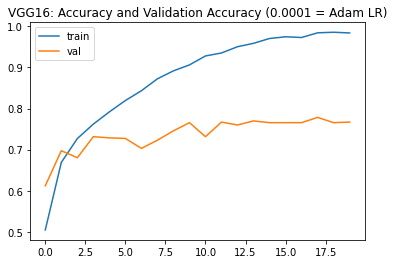

In [0]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16: Loss and Validation Loss (0.0001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16: Accuracy and Validation Accuracy (0.0001 = Adam LR)')
plt.legend();
plt.show()